# Algorítmo de ML para pronóstico de precios de acciones


Aplicaremos un algoritmo de ML para predecir el precio de las acciones y crear una estrategia de trading

### Resumen
* Cómo funciona teóricamente un algoritmo de Regresión Lineal
* Predecir el precio de las acciones utilizando una regresión lineal
* Crear una estrategia de trading




In [ ]:
! pip install yfinance --upgrade --no-cache-dir
! pip install ta

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import warnings
warnings.filterwarnings("ignore")
import yfinance as yf
import ta

In [4]:
import matplotlib as mpl
from matplotlib import cycler

colors = cycler('color',
                ['#669FEE', '#66EE91', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('figure', facecolor='#313233')
plt.rc('axes', facecolor="#313233", edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors,
       labelcolor='gray')
plt.rc('grid', color='474A4A', linestyle='solid')
plt.rc('xtick', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('legend', facecolor="#313233", edgecolor="#313233")
plt.rc("text", color="#C9C9C9")
plt.rc('figure', facecolor='#313233')

# Predecir el precio de las acciones utilizando una regresión lineal


### Importar los datos de Yahoo



In [5]:
# Importar los datos
df = yf.download("GOOG",auto_adjust=False)

# Nos quedamos con el cierre ajustado
df = df[["Adj Close"]]

# Renombra la columna
df.columns = ["close"]
df

[*********************100%***********************]  1 of 1 completed


,close
Date,
2004-08-19,2.487352
2004-08-20,2.684922
2004-08-23,2.711942
2004-08-24,2.599647
2004-08-25,2.627658
...,...
2025-05-05,166.050003
2025-05-06,165.199997
2025-05-07,152.800003


### Ingeniería de Características



In [6]:
def feature_engineering(df):
    """ Crear nuevas variables"""

    # Copiamos el dataframe para evitar interferencias en los datos
    df_copy = df.dropna().copy()

    # Crear el retorno
    df_copy["returns"] = df_copy["close"].pct_change(1)

    # Crear las SMAs
    df_copy["SMA 15"] = df_copy[["close"]].rolling(15).mean().shift(1)
    df_copy["SMA 60"] = df_copy[["close"]].rolling(60).mean().shift(1)

    # Crear las volatilidades
    df_copy["MSD 10"] = df_copy[["returns"]].rolling(10).std().shift(1)
    df_copy["MSD 30"] = df_copy[["returns"]].rolling(30).std().shift(1)

    # Crear el RSI
    RSI = ta.momentum.RSIIndicator(df_copy["close"], window= 14, fillna = False)
    df_copy["rsi"] = RSI.rsi()

    return df_copy.dropna()

In [7]:
dfc = feature_engineering(df)
dfc

,close,returns,SMA 15,SMA 60,MSD 10,MSD 30,rsi
Date,,,,,,,
2004-11-12,4.511639,-0.005573,4.528645,3.376182,0.045158,0.045223,60.962947
2004-11-15,4.582785,0.015769,4.544461,3.409920,0.045046,0.045295,62.484295
2004-11-16,4.277133,-0.066696,4.540280,3.441551,0.044225,0.045283,52.938985
2004-11-17,4.276142,-0.000232,4.524976,3.467637,0.048354,0.047390,52.910752
2004-11-18,4.153188,-0.028754,4.502716,3.495579,0.048425,0.047302,49.392434
...,...,...,...,...,...,...,...
2025-05-05,166.050003,0.001447,159.278665,167.706114,0.017089,0.028699,56.502000
2025-05-06,165.199997,-0.005119,159.721999,167.255448,0.013597,0.028672,55.210366
2025-05-07,152.800003,-0.075060,159.970665,166.893330,0.013027,0.028388,40.621648


### Crear diferentes conjuntos de datos

In [8]:
dfc.columns

Index(['close', 'returns', 'SMA 15', 'SMA 60', 'MSD 10', 'MSD 30', 'rsi'], dtype='object')

In [9]:
# Porcentaje del conjunto de entrenamiento
split = int(0.80*len(dfc))

# Crear el conjunto de entrenamiento
X_train = dfc[['SMA 15', 'SMA 60', 'MSD 10', 'MSD 30', 'rsi']].iloc[:split]
y_train = dfc[["returns"]].iloc[:split]


# Crear el conjunto de testing
X_test = dfc[['SMA 15', 'SMA 60', 'MSD 10', 'MSD 30', 'rsi']].iloc[split:]
y_test = dfc[["returns"]].iloc[split:]

### Entrenamiento de regresión lineal

In [10]:
# Import la clase
from sklearn.linear_model import LinearRegression

# Inicializar la clase
reg = LinearRegression()

# Ajustar el modelo
reg.fit(X_train, y_train)

LinearRegression()

### Predicciones de regresión lineal

<Axes: xlabel='Date'>

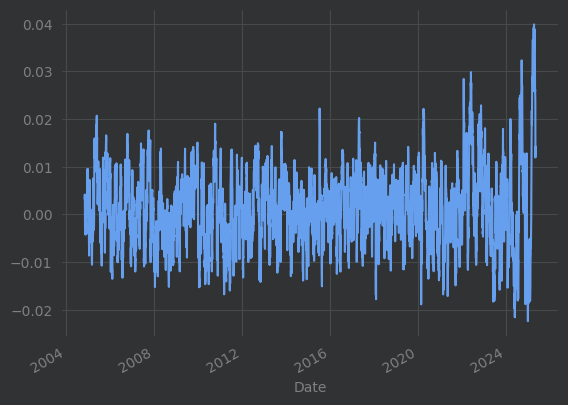

In [11]:
# Crear predicciones para todo el conjunto de datos
X = np.concatenate((X_train, X_test), axis=0)

dfc["prediction"] = reg.predict(X)

# Verificamos que el algoritmo no predice de un sólo modo (positiva o negativa)
dfc["prediction"].plot()

### Calcular el beneficio

In [12]:
# Calculamos la posición
dfc["position"] = np.sign(dfc["prediction"])


<Axes: xlabel='Date'>

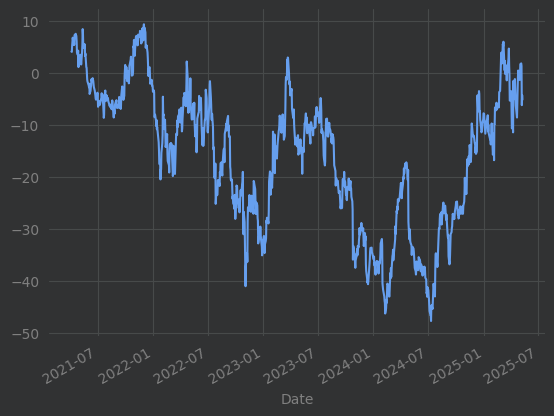

In [13]:
# Calcular el beneficio
dfc["strategy"] = dfc["returns"] * dfc["position"].shift(1)


(dfc["strategy"].iloc[split:].cumsum()*100).plot()

In [16]:
def lin_reg_trading(symbol):

  def feature_engineering(df):
    """ Create new variables"""

    # Copiamos el marco de datos para evitar interferencias en los datos
    df_copy = df.dropna().copy()

    # Calcular el retorno
    df_copy["returns"] = df_copy["close"].pct_change(1)

    # Crear las SMAs
    df_copy["SMA 15"] = df_copy[["close"]].rolling(15).mean().shift(1)
    df_copy["SMA 60"] = df_copy[["close"]].rolling(60).mean().shift(1)

    # Crear las volatilidades
    df_copy["MSD 10"] = df_copy[["returns"]].rolling(10).std().shift(1)
    df_copy["MSD 30"] = df_copy[["returns"]].rolling(30).std().shift(1)

    # Crear las RSI
    RSI = ta.momentum.RSIIndicator(df_copy["close"], window= 14, fillna = False)
    df_copy["rsi"] = RSI.rsi()

    return df_copy.dropna()


  # Importar los datos
  df = yf.download(symbol)

  # Use 'Close' instead of 'Adj Close' if 'Adj Close' is not found
  if "Adj Close" in df.columns:
      df = df[["Adj Close"]]
  else:
      df = df[["Close"]] # Assume 'Close' exists if 'Adj Close' is not present

  # Rename the column
  df.columns = ["close"]

  dfc = feature_engineering(df)

  # Percentage train set
  split = int(0.80*len(dfc))

  # Train set creation
  X_train = dfc[['SMA 15', 'SMA 60', 'MSD 10', 'MSD 30', 'rsi']].iloc[:split]
  y_train = dfc[["returns"]].iloc[:split]


  # Test set creation
  X_test = dfc[['SMA 15', 'SMA 60', 'MSD 10', 'MSD 30', 'rsi']].iloc[split:]
  y_test = dfc[["returns"]].iloc[split:]

  # Import the class
  from sklearn.linear_model import LinearRegression

  # Initialize the class
  reg = LinearRegression()

  # Fit the model
  reg.fit(X_train, y_train)

  # Create predictions for the whole dataset
  X = np.concatenate((X_train, X_test), axis=0)

  dfc["prediction"] = reg.predict(X)

  # Compute the position
  dfc["position"] = np.sign(dfc["prediction"])

  # Compute the returns
  dfc["strategy"] = dfc["returns"] * dfc["position"].shift(1)


  (dfc["strategy"].iloc[split:].cumsum()*100).plot()

[*********************100%***********************]  1 of 1 completed


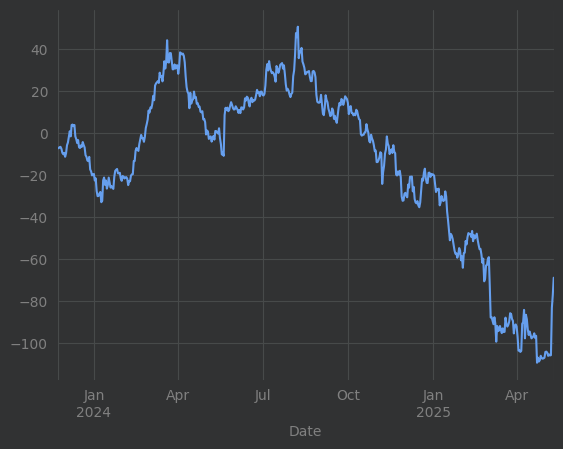

In [17]:
lin_reg_trading("ETH-EUR")